# Titanic competition

In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import polars as pl
pl.Config.set_ascii_tables(True) # print ascii tables is important for kaggle api
import matplotlib.pyplot as plt
import plotly.express as px
import warnings

# ignore warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (20, 10)
import plotly.graph_objects as go

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

PATH_TO_DATA = "../input/titanic"
import os
for dirname, _, filenames in os.walk(PATH_TO_DATA):
    print(dirname)
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../input/titanic
../input/titanic\gender_submission.csv
../input/titanic\test.csv
../input/titanic\titanic.zip
../input/titanic\train.csv


In [23]:
import glob
from sklearn.model_selection import train_test_split

# We prepare the test and train data
df = pl.read_csv(f'{PATH_TO_DATA}/train.csv')
splits = train_test_split(df, test_size=0.25, random_state=0, shuffle=True, stratify=df.select("Survived"),)
train: pl.DataFrame = splits[0]
test: pl.DataFrame = splits[1]

if len(glob.glob('{PATH_TO_DATA}/**/train_sampled.csv', recursive=True)) == 0:
    train.write_csv(f'{PATH_TO_DATA}/train_sampled.csv')
    test.write_csv(f'{PATH_TO_DATA}/test_sampled.csv')

In [25]:
train.describe()

describe,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
str,f64,f64,f64,str,str,f64,f64,f64,str,f64,str,str
"""count""",668.0,668.0,668.0,"""668""","""668""",668.0,668.0,668.0,"""668""",668.0,"""668""","""668"""
"""null_count""",0.0,0.0,0.0,"""0""","""0""",136.0,0.0,0.0,"""0""",0.0,"""515""","""2"""
"""mean""",444.244012,0.383234,2.299401,null,null,29.796842,0.502994,0.363772,null,33.273328,null,null
"""std""",260.923752,0.486539,0.841324,null,null,14.477953,1.061098,0.7846,null,53.472183,null,null
"""min""",2.0,0.0,1.0,"""Abbott, Mr. Ro…","""female""",0.42,0.0,0.0,"""110152""",0.0,"""A10""","""C"""
"""25%""",218.0,0.0,2.0,null,null,20.0,0.0,0.0,null,7.925,null,null
"""50%""",445.0,0.0,3.0,null,null,29.0,0.0,0.0,null,14.4542,null,null
"""75%""",676.0,1.0,3.0,null,null,38.0,1.0,0.0,null,30.5,null,null
"""max""",891.0,1.0,3.0,"""van Melkebeke,…","""male""",80.0,8.0,6.0,"""WE/P 5735""",512.3292,"""T""","""S"""


In [5]:
train.head()

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str
672,0,1,"""Davidson, Mr. …","""male""",31.0,1,0,"""F.C. 12750""",52.0,"""B71""","""S"""
418,1,2,"""Silven, Miss. …","""female""",18.0,0,2,"""250652""",13.0,null,"""S"""
635,0,3,"""Skoog, Miss. M…","""female""",9.0,3,2,"""347088""",27.9,null,"""S"""
324,1,2,"""Caldwell, Mrs.…","""female""",22.0,1,1,"""248738""",29.0,null,"""S"""
380,0,3,"""Gustafsson, Mr…","""male""",19.0,0,0,"""347069""",7.775,null,"""S"""


# The goal of this part is to make the simplest and straightforward model to get a baseline.

let's use a logistic regression with a simple pipeline.

In [ ]:
!pip install feature_engine
!pip install mlflow

In [ ]:
import mlflow
from mlflow import log_metric
from mlflow.models import infer_signature

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

# Create a new MLflow Experiment
mlflow.set_experiment("titanic classification")

In [27]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import  StandardScaler, OneHotEncoder
from sklearn.compose import  make_column_transformer, make_column_selector
from feature_engine.imputation import MeanMedianImputer
from feature_engine.selection import DropFeatures
from feature_engine.encoding import OneHotEncoder
from feature_engine.imputation import CategoricalImputer


X_train_pd = train.select(pl.exclude("Survived")).to_pandas()
y_train_pd = train.select(pl.col("Survived")).to_pandas()
X_test_pd = test.select(pl.exclude("Survived")).to_pandas()
y_test_pd = test.select(pl.col("Survived")).to_pandas()

# Dropping features that needs more work to be used
pipe_lr = make_pipeline(
    DropFeatures(['Cabin', 'PassengerId', 'Name', "Ticket"]), 
    CategoricalImputer(), 
    MeanMedianImputer(), 
    make_column_transformer(
        (StandardScaler(),
        make_column_selector(dtype_include=np.number)),
        (OneHotEncoder(drop_last=True), make_column_selector(dtype_include='category')),
        sparse_threshold = 0),
    LogisticRegression(),
    )

with mlflow.start_run(run_name='Logistic regressor') as run:
    columns_object = X_train_pd.select_dtypes(include='object').columns
    X_train_pd = X_train_pd.astype({col: 'category' for col in columns_object})
    X_test_pd = X_test_pd.astype({col: 'category' for col in columns_object})

    pipe_lr.fit(X_train_pd, y_train_pd)

    # Log the metrics
    log_metric("train_accuracy_score", float(pipe_lr.score(X_train_pd, y_train_pd)))
    log_metric("testing_accuracy_score", float(pipe_lr.score(X_test_pd, y_test_pd)))

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Basic LR model for titanic data")

    # Infer the model signature
    signature = infer_signature(X_train_pd, pipe_lr.predict(X_train_pd))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=pipe_lr,
        artifact_path="titanic_model",
        signature=signature,
        input_example=X_train_pd,
        registered_model_name="lr_pipeline",
    )

    # Log the parameters
    mlflow.log_param("drop_features", "Cabin, PassengerId, Name, Ticket")
    mlflow.log_param("numerical imputer", "MeanMedianImputer")
    mlflow.log_param("categorical imputer", "CategoricalImputer")
    mlflow.log_param("scaler", "StandardScaler")
    mlflow.log_param("encoder", "OneHotEncoder")
    mlflow.log_param("model_type", "LogisticRegression")

    print("Run ID: {} experiment ID: {}".format(run.info.run_id, run.info.experiment_id))

Registered model 'lr_pipeline' already exists. Creating a new version of this model...
2024/09/29 16:23:02 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: lr_pipeline, version 4
Created version '4' of model 'lr_pipeline'.


Run ID: e79c017ff0de493397983333217ea2af experiment ID: 969349413620753544


# Let's improve the model

In [1]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.decomposition import PCA

X_train_tr = pipe_lr[:-1].transform(X_train_pd)
ranking = {'mutual_info_classif': pd.Series(mutual_info_classif(X_train_tr, y_train_pd)).sort_values(ascending=False).index,
           'f_classif':pd.Series(f_classif(X_train_tr, y_train_pd)[0]).sort_values(ascending=False).index, 
           'PCA': PCA}

NameError: name 'pipe_lr' is not defined

In [34]:
ranking

{'mutual_info_classif': Index([5, 4, 0, 7, 1, 2, 3, 6, 8], dtype='int64'),
 'f_classif': Index([5, 0, 4, 7, 6, 3, 8, 1, 2], dtype='int64'),
 'PCA': sklearn.decomposition._pca.PCA}

In [7]:
df_cabin_prefix = train.with_columns(pl.col("Cabin").str.replace("\d+", "", n=-1).apply(lambda x: x[0]).alias("Cabin_prefix"))
fig = px.box(df_cabin_prefix.sort("Cabin_prefix"), x="Fare", y="Cabin_prefix", color="Cabin_prefix")
fig.show()

In [8]:
fig = px.box(train, x="Fare", y="Embarked", color="Embarked")
fig.show()

In [9]:
df = train.groupby("Embarked").agg(pl.col("Survived").sum()/pl.col("Survived").count(), pl.col("Fare").mean()).filter(pl.col("Embarked").is_not_null())
fig = px.bar(df, x="Embarked", y="Survived", color="Embarked", orientation="v")
fig.show()

In [10]:
import itertools

survived = pl.col("Survived")
died = pl.col("Died")

sum_s_d = (pl.col("Survived_right") + pl.col("Died_right"))

df_gr_cabin_class = df_cabin_prefix.groupby(["Cabin_prefix", "Pclass"]).agg(
    survived.sum(),
    (survived - 1).abs().sum().alias("Died"),)

df_gr_cabin = df_cabin_prefix.groupby(["Cabin_prefix"]).agg(
    survived.sum(),
    (survived - 1).abs().sum().alias("Died"),)

df_gr_cabin_class = df_gr_cabin_class.join(
        df_gr_cabin,
        on="Cabin_prefix",
    ).with_columns(
        (survived /  sum_s_d).alias("Survival_rate"),
        (died / sum_s_d).alias("death_rate"),
    ).fill_null("null")

In [11]:
classes = df_gr_cabin_class.select("Pclass").unique().to_series().sort()

prod = list(itertools.product(classes, df_gr_cabin_class.select("Cabin_prefix").unique().to_series()))

new_df = pl.DataFrame(
    {"Pclass": [x[0] for x in prod], "Cabin_prefix": [x[1] for x in prod]}
).join(
        df_gr_cabin_class, on=["Pclass", "Cabin_prefix"], how="left"
        ).fill_null(0)

colors = ['rgba(158,202,225,1)', 'rgba(208,202,245,1)', 'rgba(138,252,225,1)','rgba(158,202,225,0.5)', 'rgba(208,202,245,0.5)', 'rgba(138,252,225,0.5)']
fig = go.Figure()

_map = {
    'Survived':"Survivors",
    'Died':"deaths"
}

for idx, keys in enumerate(itertools.product(['Survived','Died'], classes)):
    d = new_df.filter((pl.col("Pclass") == keys[1])).to_pandas().sort_values("Cabin_prefix")
    fig.add_trace(go.Bar(
        name=f"class {keys[1]}",
        y=d[keys[0]],
        x=d.Cabin_prefix,
        marker_color=colors[idx],
        legendgroup=keys[0],
        legendgrouptitle_text=f"{_map[keys[0]]} group",
        ))
    
fig.update_layout(title="Survivors and deaths by cabin and class", barmode='stack')

fig.update_yaxes(type="log", range=[-(1/5), 3]) # log range: 10^0=1, 10^5=100000

fig.show()

In [18]:
from sklearn.preprocessing import FunctionTransformer
from feature_engine.encoding import MeanEncoder
from copy import deepcopy
import pandas as pd

def _extractName(x: pd.DataFrame):
    x['Last_Name'] = x.Name.str.replace(')', '').str.split(' ').apply(lambda x: x[-1]).to_frame()
    x['Fare'] = x['Fare'].fillna(x['Fare'].mean())
    x['Last_Name'] = MeanEncoder().fit_transform(x['Last_Name'].to_frame(), x['Fare'])
    return x[['Last_Name', 'Fare']]

fnTransformer = FunctionTransformer(lambda x: x.str.replace("\d+", "", n=-1).fillna("null").apply(lambda x: x[0] if x != "null" else x).to_frame())
extractName = FunctionTransformer(_extractName)
pipe_2 = make_pipeline( DropFeatures(['PassengerId', "Ticket"]), make_column_transformer(
    (fnTransformer, "Cabin"),
    (extractName, ["Name", "Fare"]),
    remainder="passthrough"), deepcopy(pipe[1:]))

with mlflow.start_run(run_name='titanic classification with Cabin') as run:
    pipe_2.fit(X, y)
    log_metric("testing_accuracy_score", float(pipe_2.score(X_test, y_test)))

    print("Run ID: {} experiment ID: {}".format(run.info.run_id, run.info.experiment_id))

2023/09/10 00:45:13 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('dropfeatures', DropFeatures(features_to_drop=['PassengerId', 'Ticket'])), ('columntransformer', ColumnTransformer(remainder='passthrough',
                  transformers=[('functiontransformer-1',
                                 FunctionTransformer(func=<function <lambda> at 0x000001DA72ED1940>),
                                 'Cabin'),
                                ('functiontransformer-2',
                                 FunctionTransformer(func=<function _extractName at 0x000001DA...`
2023/09/10 00:45:13 WARNING mlflow.utils: Truncated the value of the key `pipeline`. Truncated value: `Pipeline(steps=[('categoricalimputer', CategoricalImputer()),
                ('meanmedianimputer', MeanMedianImputer()),
                ('columntransformer',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('standardscaler',
            

Run ID: 0b8cd7d81f5a4bfabc48f9142665cef7 experiment ID: 0


c:\Users\gaetd\AppData\Local\pypoetry\Cache\virtualenvs\kaggle-titanic-5fA9pY_j-py3.11\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\gaetd\AppData\Local\pypoetry\Cache\virtualenvs\kaggle-titanic-5fA9pY_j-py3.11\Lib\site-packages\feature_engine\imputation\categorical.py:232: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



gives us a spatial information about people. Where they were in the boat. We can use this information to improve our model.

Does the embarkation port have an impact on the cabin?

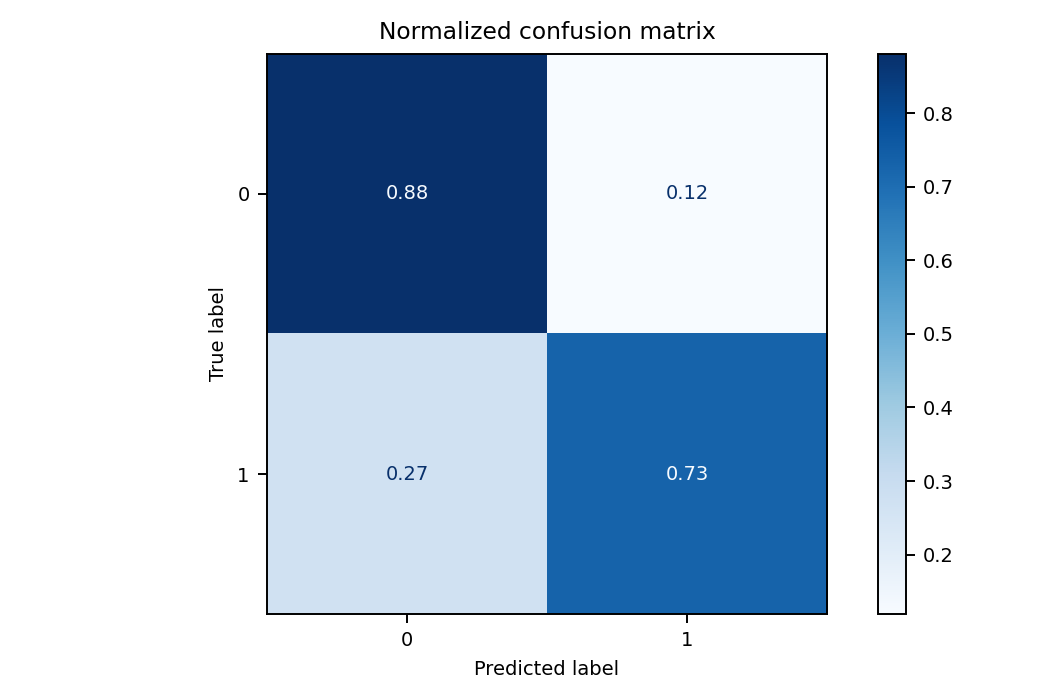

In [19]:
from mlflow import MlflowClient
from mlflow.entities import ViewType

def fetch_logged_data(client, run_id):
    data = client.get_run(run_id).data
    tags = {k: v for k, v in data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in client.list_artifacts(run_id, "model")]
    return data.params, data.metrics, tags, artifacts

def get_best_run_data():
    client = MlflowClient()
    run = client.search_runs(
    experiment_ids="0",
    filter_string="",
    run_view_type=ViewType.ALL,
    order_by=["metrics.testing_accuracy_score DESC"],
    )[0]

    return run, fetch_logged_data(client, run.info.run_id)


run, (params, metrics, tags, artifacts) = get_best_run_data()

from IPython.display import Image
Image(mlflow.artifacts.download_artifacts(run_id=run.info.run_id, artifact_path="training_confusion_matrix.png"))

In [23]:
metrics

{'Pipeline_score_X_test': 0.8116591928251121,
 'testing_accuracy_score': 0.8116591928251121,
 'training_accuracy_score': 0.8233532934131736,
 'training_f1_score': 0.8218558836551841,
 'training_log_loss': 0.3997009600023225,
 'training_precision_score': 0.8219190150771902,
 'training_recall_score': 0.8233532934131736,
 'training_roc_auc': 0.889183859223301,
 'training_score': 0.8233532934131736}

# Submission

In [ ]:
PATH_TO_OUTPUT = "output"

!mkdir output

In [27]:
def create_submission(run):
    logged_model = mlflow.artifacts.download_artifacts(run_id=run.info.run_id, artifact_path="model")

    # Load model as a PyFuncModel.
    loaded_model = mlflow.pyfunc.load_model(logged_model)

    test = pd.read_csv(f'{PATH_TO_DATA}/test.csv')
    results = loaded_model.predict(test)

    pd.concat([test.PassengerId, pd.Series(results, name="Survived")], axis=1).to_csv(f'{PATH_TO_OUTPUT}/submission.csv', index=False)

create_submission(run)

c:\Users\gaetd\AppData\Local\pypoetry\Cache\virtualenvs\kaggle-titanic-5fA9pY_j-py3.11\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\gaetd\AppData\Local\pypoetry\Cache\virtualenvs\kaggle-titanic-5fA9pY_j-py3.11\Lib\site-packages\feature_engine\imputation\categorical.py:232: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Then run this command `kaggle competitions submit -c titanic -f submission.csv -m "MLflow and logistic regressor"`

In [22]:
!kaggle competitions submit -c titanic -f submission.csv -m "MLflow and logistic regressor"

Successfully submitted to Titanic - Machine Learning from Disaster



  0%|          | 0.00/3.18k [00:00<?, ?B/s]
100%|██████████| 3.18k/3.18k [00:00<00:00, 6.55kB/s]
